# Python Assignment 2 - Text Classification
**Dagoberto Romer**

## Importing Libraries

In [1]:
import time
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import jtplot module in notebook
from jupyterthemes import jtplot
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='gruvboxd')

## Importing Text Data

In [4]:
start_script = time.time()

In [5]:
from sklearn.datasets import load_files

The folder "unsup" inside the train folder was deleted as those are not labeled. Becuase we're working on windos and to avoid unsupported commands, we removed the folder manually

We use the `load_files()` function in sklearn as it already reads the folder structure as is and assigns targets depending on the name of the folders, pos = 1 and neg = 0.  
We also use `load_content=True` and encoding utf8 so it reads it as a String instead of a Byte so we can use feature extraction classes in sklearn

**Note:** This text loading function might take a few minutes, I suspect it has to do with the Windows Defender as its CPU usage shoots up as well. I can only guess that it's scanning every file as it loads. On my Desktop it takes about 3 minutes to load

In [6]:
reviews_train = load_files("./aclImdb/train/", load_content=True,
                           encoding='utf8', categories=['pos', 'neg'])
reviews_test = load_files("./aclImdb/test/", load_content=True,
                          encoding='utf8', categories=['pos', 'neg'])

In [7]:
train = pd.DataFrame(reviews_train.data, columns=['review'])
train['sentiment'] = reviews_train.target
test = pd.DataFrame(reviews_test.data, columns=['review'])
test['sentiment'] = reviews_test.target

In [8]:
train.head()

,review,sentiment
0,"Zero Day leads you to think, even re-think why...",1
1,Words can't describe how bad this movie is. I ...,0
2,Everyone plays their part pretty well in this ...,1
3,There are a lot of highly talented filmmakers/...,0
4,I've just had the evidence that confirmed my s...,0


In [9]:
test.head()

,review,sentiment
0,Don't hate Heather Graham because she's beauti...,1
1,I don't know how this movie has received so ma...,0
2,I caught this movie on the Horror Channel and ...,1
3,NBC had a chance to make a powerful religious ...,0
4,Looking for something shocking? Okay fine... t...,0


We have a DataFrame for each train and test sets. Consisting fo 2 columns, text and target

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review       25000 non-null object
sentiment    25000 non-null int32
dtypes: int32(1), object(1)
memory usage: 293.0+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review       25000 non-null object
sentiment    25000 non-null int32
dtypes: int32(1), object(1)
memory usage: 293.0+ KB


Each set has 25000 entries

In [12]:
train.groupby('sentiment').count()

,review
sentiment,
0,12500
1,12500


In [13]:
test.groupby('sentiment').count()

,review
sentiment,
0,12500
1,12500


Each set is equally divided by 50% bad sentiment (0) and good sentiment (1).  
We can then use accuracy as our main metric as there is no inbalance in the set.

## Data Quality Issues

We know that we have some html breaks as `<br />` that we can replace with regular spaces.  
We also have some punctuations, numbers and single character words that don't provide any additional information so we want to remove them.  
We create a function we can pass through the Dataframe so we can apply it to every review. As we will use replace to take out the breaks. we will run 2 different applies

In [14]:
def clean_line(line):
    # split into tokens by white space
    tokens = line.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    line = " ".join(tokens)
    return line

In [15]:
# Train Set:
train['review'] = train['review'].apply(lambda x: x.replace("<br />", " "))
train['review'] = train['review'].apply(lambda line: clean_line(line))

# Test Set
test['review'] = test['review'].apply(lambda x: x.replace("<br />", " "))
test['review'] = test['review'].apply(lambda line: clean_line(line))

We check the text of one review we knew it contained a break and "sub-par"

In [16]:
train.iloc[5]['review']

'The Movie was subpar but this Television Pilot delivers great springboard into what has become SciFi fans Ideal program The Actors deliver and the special effects for television series are spectacular Having an intelligent interesting script doesnt hurt either Stargate is currently one of my favorite programs'

## Preprocessing

### X/y Split

First we split our Data into features and targets, Text Feature functions like CountVectorizer and TfidfVectorizer require the text to be set as a list of document instead of a dataframe or a pd.Series. So we will change our data to match that accordingly

In [17]:
X_train = train['review'].tolist()
y_train = train['sentiment']
X_test = test['review'].tolist()
y_test = test['sentiment']

### Text Features

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

We can use either CountVectorizer or TfidfVectorizer:  
 - CountVectorizer simply counts ever 2 or more letter word, all in lowercase and split by any word boundaries
 - TFIDF calculates the Term Frecuency and Inverse Document Frecuency, giving less importance to words that appear in every document (words that are very common and not representative)

Another thing that's useful is to remove stopwords in our set. This is basically removing words that are so common in the language that they provide basically no information for text analysis.  
Lastly we set a minimum appeareance of 5 to remove all words that were mispelled or particular to only 1 document

**We'll start using the simpler `CountVectorizer()`**

In [19]:
vect = CountVectorizer(min_df=5, stop_words='english')

In [20]:
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [21]:
new_X_train = vect.transform(X_train)
new_X_train

<25000x28001 sparse matrix of type '<class 'numpy.int64'>'
	with 2102670 stored elements in Compressed Sparse Row format>

This gives us a sparse matrix if 25000 rows by almost 27k features. If we had left the `min_df=1` and the stopwords, this would've been more than 70k features

## ML Section

In [22]:
start_ml_basic = time.time()

### Basic Model

As we have a very wide sparse matrix where features > rows, a linear model is our best bet

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV

In [24]:
lr_model = LogisticRegression()

In [25]:
cv_scores = cross_val_score(lr_model, new_X_train, y_train, cv=10, n_jobs=-1)
print("Mean Cross Validation Accuracy: {}".format(round(np.mean(cv_scores), 2)))

Mean Cross Validation Accuracy: 0.87


We can also try to optimize the model by gridsearching for the C parameter in the model

In [26]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [27]:
grid = GridSearchCV(LogisticRegression(),
                    param_grid=param_grid, cv=5, n_jobs=-1)

In [28]:
grid.fit(new_X_train, y_train)
print("Best CV Score: {}".format(grid.best_score_))
print("Best Parameters: {}".format(grid.best_params_))

Best CV Score: 0.88192
Best Parameters: {'C': 0.1}


In [29]:
pd.DataFrame(grid.cv_results_).loc[:, ['param_C', 'mean_test_score']]

,param_C,mean_test_score
0,0.001,0.84228
1,0.01,0.87628
2,0.1,0.88192
3,1,0.87280
4,10,0.86548
5,100,0.86036


We also test our data against the test set (transformed by the same vectorizer) to make sure our model is able to generalize with new data

In [30]:
# Use the same vectorizer to have the same features
new_X_test = vect.transform(X_test)

In [31]:
grid.score(new_X_test, y_test)

0.87344

The score is fairly close to our Cross Validation Score. So our model is generalizing well

### Advanced Model 1

In [32]:
start_ml_adv = time.time()

For the 1st advanced model we will use:  
 - NLTK Stopwords
 - Lemmatization (commented out because of time requirements)
 - TFIDF
 - Up to 3 words ngrams
 - Model Tuning using Pipelines

In [33]:
from sklearn.pipeline import make_pipeline
from nltk import WordNetLemmatizer as wnl
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dagoberto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dagoberto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We will reprocess the data to do lemmatization. This process can take a couple of minutes to run:  
 - Lemmatization works by transforming the word into it's lemma. This is based on using WordNet's morphy


In [34]:
# Lemmatization Example
word = 'feet'
print(wnl().lemmatize(word))
print(wnl().lemmatize('hanging'))

foot
hanging


**Potential problem:**  
We have some words that can have different meanings. So we need to specify the Part of Speech part to the lemmatizer if we want to correctly lemmatize the words, if they are verbs or nouns, etc. In our example, hanging was kept as hanging because we didn't specify it was a verb.  The package we're using allows us to do that but Spacy allows us to do it much easier and faster


**Note:** If you want to run the spacy lemmatization you might not be able to run the Convolutional Neural Network and the LSTM. After testing, the lemmatization also didn't have any improvement on the scores

In [35]:
# import spacy
# nlp = spacy.load('en', disable=['parser', 'ner'])

In [36]:
# We create a lemmatizer function here
# def lemmatizer_spacy(line):
#    doc = nlp(line)
#    line = " ".join([token.lemma_ for token in doc])
#    return line

In [37]:
# Testing
# line = "We are running from hanging hangers because you and I are not here"
# lemmatizer_spacy(line)

In our nonsensical example, we can see how it differentiates hanging as  a verb, and hangers as the plural of hanger and pronouns are just -PRON-  and are turns into be. So we will use this on our files and see if it makes it better.  
**Note:** As this will take a long time to train, we will do it separately instead of in the pipeline so it doesn't run every time (on my desktop this next cell takes 8 minutes to complete)

Lemmatization takes over 8 minutes to run and it didn't improve any of our models. We leave it commented as to be able to run the entire notebook faster. If you want to run lemmatization, uncomment the next 2 lines in the cell

In [38]:
# train['review'] = train['review'].apply(lambda x: lemmatizer_spacy(x))
# test['review'] = test['review'].apply(lambda x: lemmatizer_spacy(x))

In [39]:
X_train = train['review'].tolist()
y_train = train['sentiment']
X_test = test['review'].tolist()
y_test = test['sentiment']

In [40]:
stop_adv_preprocess = time.time()

We create a pipeline that will grab our processed data thgouhg a TFIDF Vectorizer and then into a Logistic Regression model (because of the ease and speed, we have more complicated models later on)

In [41]:
pipe = make_pipeline(TfidfVectorizer(
    min_df=5, stop_words=stopwords), LogisticRegression())

In [42]:
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
    'logisticregression__C': [5, 10, 15]
}

In [43]:
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

In [44]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  4.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'tfidfvectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)], 'logisticregression__C': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [45]:
grid.best_params_

{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 3)}

In [46]:
grid.best_score_

0.89492

We get 89.4% accuracy with this model, using (1, 3) ngram range and a C of 10.  


In [47]:
results = pd.DataFrame(grid.cv_results_)

In [48]:
res_table = results.pivot_table(
    'mean_test_score', 'param_tfidfvectorizer__ngram_range', 'param_logisticregression__C')

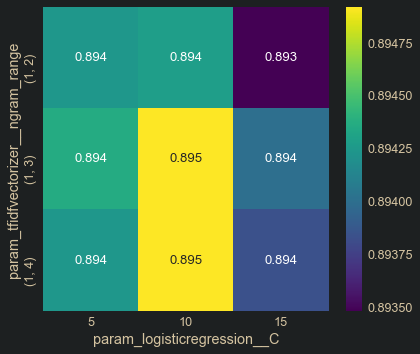

In [49]:
sns.heatmap(res_table, annot=True, fmt=".3f", cmap="viridis",)

In [50]:
print("Mean Cross Validation Accuracy: {}".format(round(grid.best_score_, 2)))

Mean Cross Validation Accuracy: 0.89


In [51]:
print("Test Score Accuracy: {}".format(round(grid.score(X_test, y_test), 2)))

Test Score Accuracy: 0.89


The numbers are really close to each other so the model is also generalizing

### Naive Bayes

In [52]:
start_ml_nb = time.time()

Naive Bayes was used a lot in spam detection filters, so it makes sense to use it for sentiment analysis as it's a binary classification problem from the words in the document.

In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin

In [54]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [55]:
pipe = make_pipeline(TfidfVectorizer(
    min_df=5, stop_words=stopwords, ngram_range=(1, 1), ), DenseTransformer(), GaussianNB())

These 2 lines are commented because Naive Bayes requires the matrix to be dense which will increase the memory footprint by a LOT. And the score is not even close to using Log Reg. So we leave it commented. Also we run into Memory Errors when we try more than 1,1 ngrams. So we have to keep it at 1,1

In [56]:
# pipe.fit(X_train, y_train)

In [57]:
# pipe.score(X_test, y_test)
# 0.6288

The score is MUCH worse than using Logistic Regression and the memory footprint to do this was huge in comparison so there is no reason to pursue this model further

### SUPER Advanced Models

For these models we're using Tensorflow and Keras as its high level API to build, train and test the models. We're going to use 3 different approaches to see if they are any better than a simple logistic regression

These models we're trained using a GTX1070 to speed up the process. Beware of running these cells with a laptop. 

For this Model we will use Neural networks
 - Dense Neural network
 - Convolutional Neural network
 - LSTM Network

From our previous experiments, we can see that (1,3) ngram was the best, but it will also increse our features substantially. As we already know 1 epoch of (1, 1) ngrams will take about 12 seconds with a GPU, we go ahead and do it for (1, 3).  
*Note*: We tried with (1, 3) ngram range but the memory requirement is higher than what we have availabe and we get a Resource Exhausted error. So we keep it at (1, 1)

In [58]:
ct_vec = CountVectorizer(stop_words=stopwords, min_df=5, ngram_range=(1, 1))
vec = TfidfVectorizer(stop_words=stopwords, min_df=5, ngram_range=(1, 1))

In [59]:
vec.fit(X_train)  # We will try the tfidf vectorizer
new_X_train = vec.transform(X_train)
new_X_test = vec.transform(X_test)

In [60]:
new_X_train

<25000x28178 sparse matrix of type '<class 'numpy.float64'>'
	with 2370371 stored elements in Compressed Sparse Row format>

#### Convolutional Neural Network

In [61]:
import tensorflow as tf

Whenever we run the Dense neural network first, we run into a problem. might be realted to memory and resources as the DNN is the one with the most parameters to train. So we will run CNN then LSTM and DNN at the end 

In [62]:
start_nn_cnn = time.time()

Convolutional Networks require the features to be in index form. Instead of a simple sparse matrix

In [63]:
word2idx = {word: idx for idx, word in enumerate(vec.get_feature_names())}
tokenize = vec.build_tokenizer()
preprocess = vec.build_preprocessor()


def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes


print(to_sequence(tokenize, preprocess, word2idx, "This is an important test!"))
X_train_sequences = [to_sequence(
    tokenize, preprocess, word2idx, x) for x in X_train]
print(X_train_sequences[0])  # This shows the words that are on every line

[12387, 25063]
[28131, 6121, 14209, 25177, 8456, 20805, 26038, 15677, 27869, 4781, 16549, 24330, 26866, 22888, 4364, 3559, 16528, 2307, 2427, 16101, 26038, 12045, 6223, 27735, 4790, 4315, 17539, 6307, 27840, 26866, 5477, 6598, 18322, 16375, 10410, 9263, 220, 20496, 19356, 25031, 8681, 16335, 207, 26038, 28064, 2287, 7903, 25031, 9246, 10313, 22829, 8932, 8932, 2287, 9246, 686, 1045, 14469, 21996, 9441, 11848, 25037, 11850]


In [64]:
# Compute the max lenght of a text
from keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LENGHT = len(max(X_train_sequences, key=len))
print("MAX_SEQ_LENGHT=", MAX_SEQ_LENGHT)

N_FEATURES = len(vec.get_feature_names())
# This creates a padded sequence so every row has the same number of features
X_train_sequences = pad_sequences(
    X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[1])

MAX_SEQ_LENGHT= 1290


Using TensorFlow backend.


[28178 28178 28178 ... 27840  2287 17413]


In [65]:
X_train_sequences.shape

(25000, 1290)

This means that the maximum review we have had 1405 words. And it meant that it grabbed every row and made it have the same ammount of "words" by padding each sequence with a number which is the last value in our features (so it's still the inside the feature matrix)

In [66]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, Dropout

model = Sequential()
model.add(Embedding(len(vec.get_feature_names()) + 1,
                    64,  # Embedding Size
                    input_length=MAX_SEQ_LENGHT))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1290, 64)          1803456   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1286, 64)          20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 257, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16448)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1052736   
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [67]:
model.fit(X_train_sequences[:-5000], y_train[:-5000],
          epochs=5, batch_size=128, verbose=2,
          validation_data=(X_train_sequences[-5000:], y_train[-5000:]),
          )

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 6s - loss: 0.5006 - acc: 0.7111 - val_loss: 0.2984 - val_acc: 0.8774
Epoch 2/5
 - 4s - loss: 0.1835 - acc: 0.9315 - val_loss: 0.2947 - val_acc: 0.8832
Epoch 3/5
 - 4s - loss: 0.0698 - acc: 0.9788 - val_loss: 0.4075 - val_acc: 0.8760
Epoch 4/5
 - 4s - loss: 0.0230 - acc: 0.9946 - val_loss: 0.5276 - val_acc: 0.8760
Epoch 5/5
 - 4s - loss: 0.0065 - acc: 0.9988 - val_loss: 0.6275 - val_acc: 0.8760


In [68]:
X_test_sequences = [to_sequence(
    tokenize, preprocess, word2idx, x) for x in X_test]
X_test_sequences = pad_sequences(
    X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [69]:
scores = model.evaluate(X_test_sequences, y_test)
print("Accuracy: {}".format(scores[1]))

25000/25000 [==============================] - 2s 77us/step
Accuracy: 0.84992


We get slightly worse scores than the original Logistic Regression

#### Dense Neural Network

In [70]:
start_nn_dnn = time.time()

Here we create our first model. Based on 1 input, 1 hidden and 1 output dense layer. Activation function is rectified linear.

In [71]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(2000, activation='relu', input_dim=len(vec.get_feature_names())))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2000)              56358000  
_________________________________________________________________
dense_5 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1001      
Total params: 58,360,001
Trainable params: 58,360,001
Non-trainable params: 0
_________________________________________________________________


Here we set our Train / Validation Set (this can done using SKLearn wrappers to make cross validation/grid search but we're so outside the scope at this point that prefered to do it this way 

In [72]:
model.fit(new_X_train[:-5000], y_train[:-5000], batch_size=128,
          epochs=5, verbose=2, validation_data=(new_X_train[-5000:], y_test[-5000:]))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 14s - loss: 0.3308 - acc: 0.8590 - val_loss: 0.2731 - val_acc: 0.8868
Epoch 2/5
 - 12s - loss: 0.0652 - acc: 0.9769 - val_loss: 0.4129 - val_acc: 0.8674
Epoch 3/5
 - 12s - loss: 0.0087 - acc: 0.9972 - val_loss: 0.7014 - val_acc: 0.8658
Epoch 4/5
 - 12s - loss: 7.0719e-04 - acc: 0.9999 - val_loss: 0.8288 - val_acc: 0.8682
Epoch 5/5
 - 12s - loss: 1.2505e-04 - acc: 1.0000 - val_loss: 0.8931 - val_acc: 0.8672


From doing 5 epochs we get a validation score around 87.5%

In [73]:
scores = model.evaluate(new_X_test, y_test)
print("Accuracy: {}".format(scores[1]))

25000/25000 [==============================] - 6s 231us/step
Accuracy: 0.84588


ALL THIS POWER AND IT DIDNT EVEN GET A BETTER SCORE!!!!

We got 87% on Validation and about 83% on Test scores. It was better to just use logistic regression

#### LSTM Network

In [74]:
start_nn_lstm = time.time()

Lastly we will use a Recurrent Neural Network, known as Long Short Term Memory network. These are used a lot in sentiment analysis and natural language processing.  
This also reuses the processing we did for the CNN. So no need to redo that 

In [75]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, CuDNNLSTM

model = Sequential()
model.add(Embedding(len(vec.get_feature_names()) + 1,
                    64,  # Embedding Size
                    input_length=MAX_SEQ_LENGHT))
model.add(CuDNNLSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1290, 64)          1803456   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                33280     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,836,801
Trainable params: 1,836,801
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(X_train_sequences[:-5000], y_train[:-5000],
          epochs=5, batch_size=128, verbose=2,
          validation_data=(X_train_sequences[-5000:], y_train[-5000:]))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
 - 9s - loss: 0.5182 - acc: 0.7540 - val_loss: 0.3303 - val_acc: 0.8644
Epoch 2/5
 - 9s - loss: 0.2135 - acc: 0.9202 - val_loss: 0.2988 - val_acc: 0.8718
Epoch 3/5
 - 9s - loss: 0.1064 - acc: 0.9671 - val_loss: 0.3540 - val_acc: 0.8718
Epoch 4/5
 - 9s - loss: 0.0559 - acc: 0.9846 - val_loss: 0.4628 - val_acc: 0.8670
Epoch 5/5
 - 9s - loss: 0.0325 - acc: 0.9913 - val_loss: 0.6057 - val_acc: 0.8634


In [77]:
scores = model.evaluate(X_test_sequences, y_test)
print("Accuracy: {}".format(scores[1]))

25000/25000 [==============================] - 14s 545us/step
Accuracy: 0.84336


I am really dissapointed now...

In [78]:
stop_script = time.time()

## Conclusions

As we can see, the best model was our simpler and first model. We tried improving it by processing the text more, lemmatizing the words, created more complex pipelines and even different kinds of neural networks to try and get a better score. Without any success. 

In this case it might be because we are not dealing with that many data points. Neural Nets get top flex their muscles when you start running millions and millions of rows through them. In this case it's really easy for the Neural net to overfit into the training data and then have a worse outcome on the validation / test data

### Time results

All results in minutes

In [79]:
print("Total Script: {}".format(
    (stop_script - start_script) / 60))
print("Data Processing: {}".format(
    (start_ml_basic - start_script) / 60))
print("Basic ML Model: {}".format(
    (start_ml_adv - start_ml_basic) / 60))
print("Lemmatization: {}".format(
    (stop_adv_preprocess - start_ml_adv) / 60))
print("Adv ML Model: {}".format(
    (start_nn_dnn - start_ml_adv) / 60))
print("Dense Neural Network: {}".format(
    (start_nn_lstm - start_nn_dnn) / 60))
print("Convolutional Neural Network: {}".format(
    (start_nn_dnn - start_nn_cnn) / 60))
print("Long Short Term Memory Network: {}".format(
    (stop_script - start_nn_lstm) / 60))

Total Script: 8.594632323582967
Data Processing: 0.29358097712198894
Basic ML Model: 0.7495545625686646
Lemmatization: 0.04672394990921021
Adv ML Model: 5.357212221622467
Dense Neural Network: 1.1299321850140889
Convolutional Neural Network: 0.5373992363611857
Long Short Term Memory Network: 1.0643523772557577


In [83]:
from keras import backend as K
import gc

In [84]:
K.clear_session()
gc.collect()

2046